Analyze how well the covariates match after performing the matching.

In [1]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import matching
from tqdm import tqdm
from collections import OrderedDict
from config import *
from style import cb, cr, cg, cp
import data
import scipy.stats
import util
import viz

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')
k_group = 'gender'

matches = pd.read_pickle(oj(DIR_PROCESSED, 'matches_gender_200.pkl'))

# match indexes are in original space [0, 30000)
# this is the same as the df.index [0, 30000)
match_keys = OrderedDict({
    f'{k_group}_0_ref': 'dist_ref0',
    f'{k_group}_0': 'dist',
    f'{k_group}_1': 'dist',
    f'{k_group}_1_ref': 'dist_ref1'
})
ks_matched = [k for k in match_keys if not 'ref' in k]
idxs_matched = matches[ks_matched].values
df_matched = df.iloc[idxs_matched.flatten()]

# add Race = Black
df['Race=Black'] = 0
df.loc[df['race4_pred'] == 'Black', 'Race=Black'] = 1
df_matched['Race=Black'] = 0
df_matched.loc[df_matched['race4_pred'] == 'Black', 'Race=Black'] = 1

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# visualize matches

In [2]:
ks = match_keys.keys()
r = {k: [] for k in match_keys.keys()}
# load the images
for i, match in tqdm(matches.iterrows()):
    for k in r.keys():
        d = df.iloc[int(match[k])]
        r[k].append(mpimg.imread(oj(DIR_IMS, d.fname_final)))

200it [00:13, 14.29it/s]


In [ ]:
for row_num in range(8):
    N_PER_ROW = 6
    N_SKIP = 1

    ks_plot = list(ks)[1: 3]
    ylabs = [k.replace('gender_0', 'Female').replace('gender_1', 'Male') for k in ks_plot]

    # plot the images
    for i, k in enumerate(ks_plot):
        if not 'ref' in k:
            annot_list = None
        else:
            annot_list = matches[match_keys[k]][row_num * N_PER_ROW: (row_num + 1) * N_PER_ROW].round(1)
        util.plot_row(r[k][::N_SKIP][row_num * N_PER_ROW: (row_num + 1) * N_PER_ROW],
                      annot_list=annot_list,
                      ylab=ylabs[i],
                      fontsize_ylab=42)
        util.savefig(f'matches_{k}_{row_num}')
        plt.show()

In [ ]:
N_PLOT = 10 # 4 for the github fig
N_SKIP = 10

ks_plot = list(ks)[1: 3]
ylabs = [k.replace('gender_0', 'Female').replace('gender_1', 'Male') for k in ks_plot]

# plot the images
for i, k in enumerate(ks_plot):
    if not 'ref' in k:
        annot_list = None
    else:
        annot_list = matches[match_keys[k]][:N_PLOT].round(1)
    util.plot_row(r[k][::N_SKIP][:N_PLOT],
                  annot_list=annot_list,
                  ylab=ylabs[i],
                  fontsize_ylab=42)
    util.savefig(f'matches_big_{k}')
#     plt.savefig(f'samples/matches_big_{k}.jpg', dpi=150)
    plt.show()

# mean diff checking

In [ ]:
ds = [df, df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, vert=False)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('means_matching')
plt.savefig('samples/matching_covariates.jpg', dpi=150)
plt.show()

# intersectional mean diffs
**means across different intersectional subgroups**

/home/ubuntu/face-disentanglement/matching_benchmarking/matching.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[k_full] = np.array(d[k1] == 1) & np.array(d[k2] == 1)
/home/ubuntu/face-disentanglement/matching_benchmarking/matching.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[k_full] = np.array(d[k1] == 1) & np.array(d[k2] == 0)
/home/ubuntu/face-disentanglement/matching_benchmarking/matching.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

<Figure size 2800x2200 with 0 Axes>

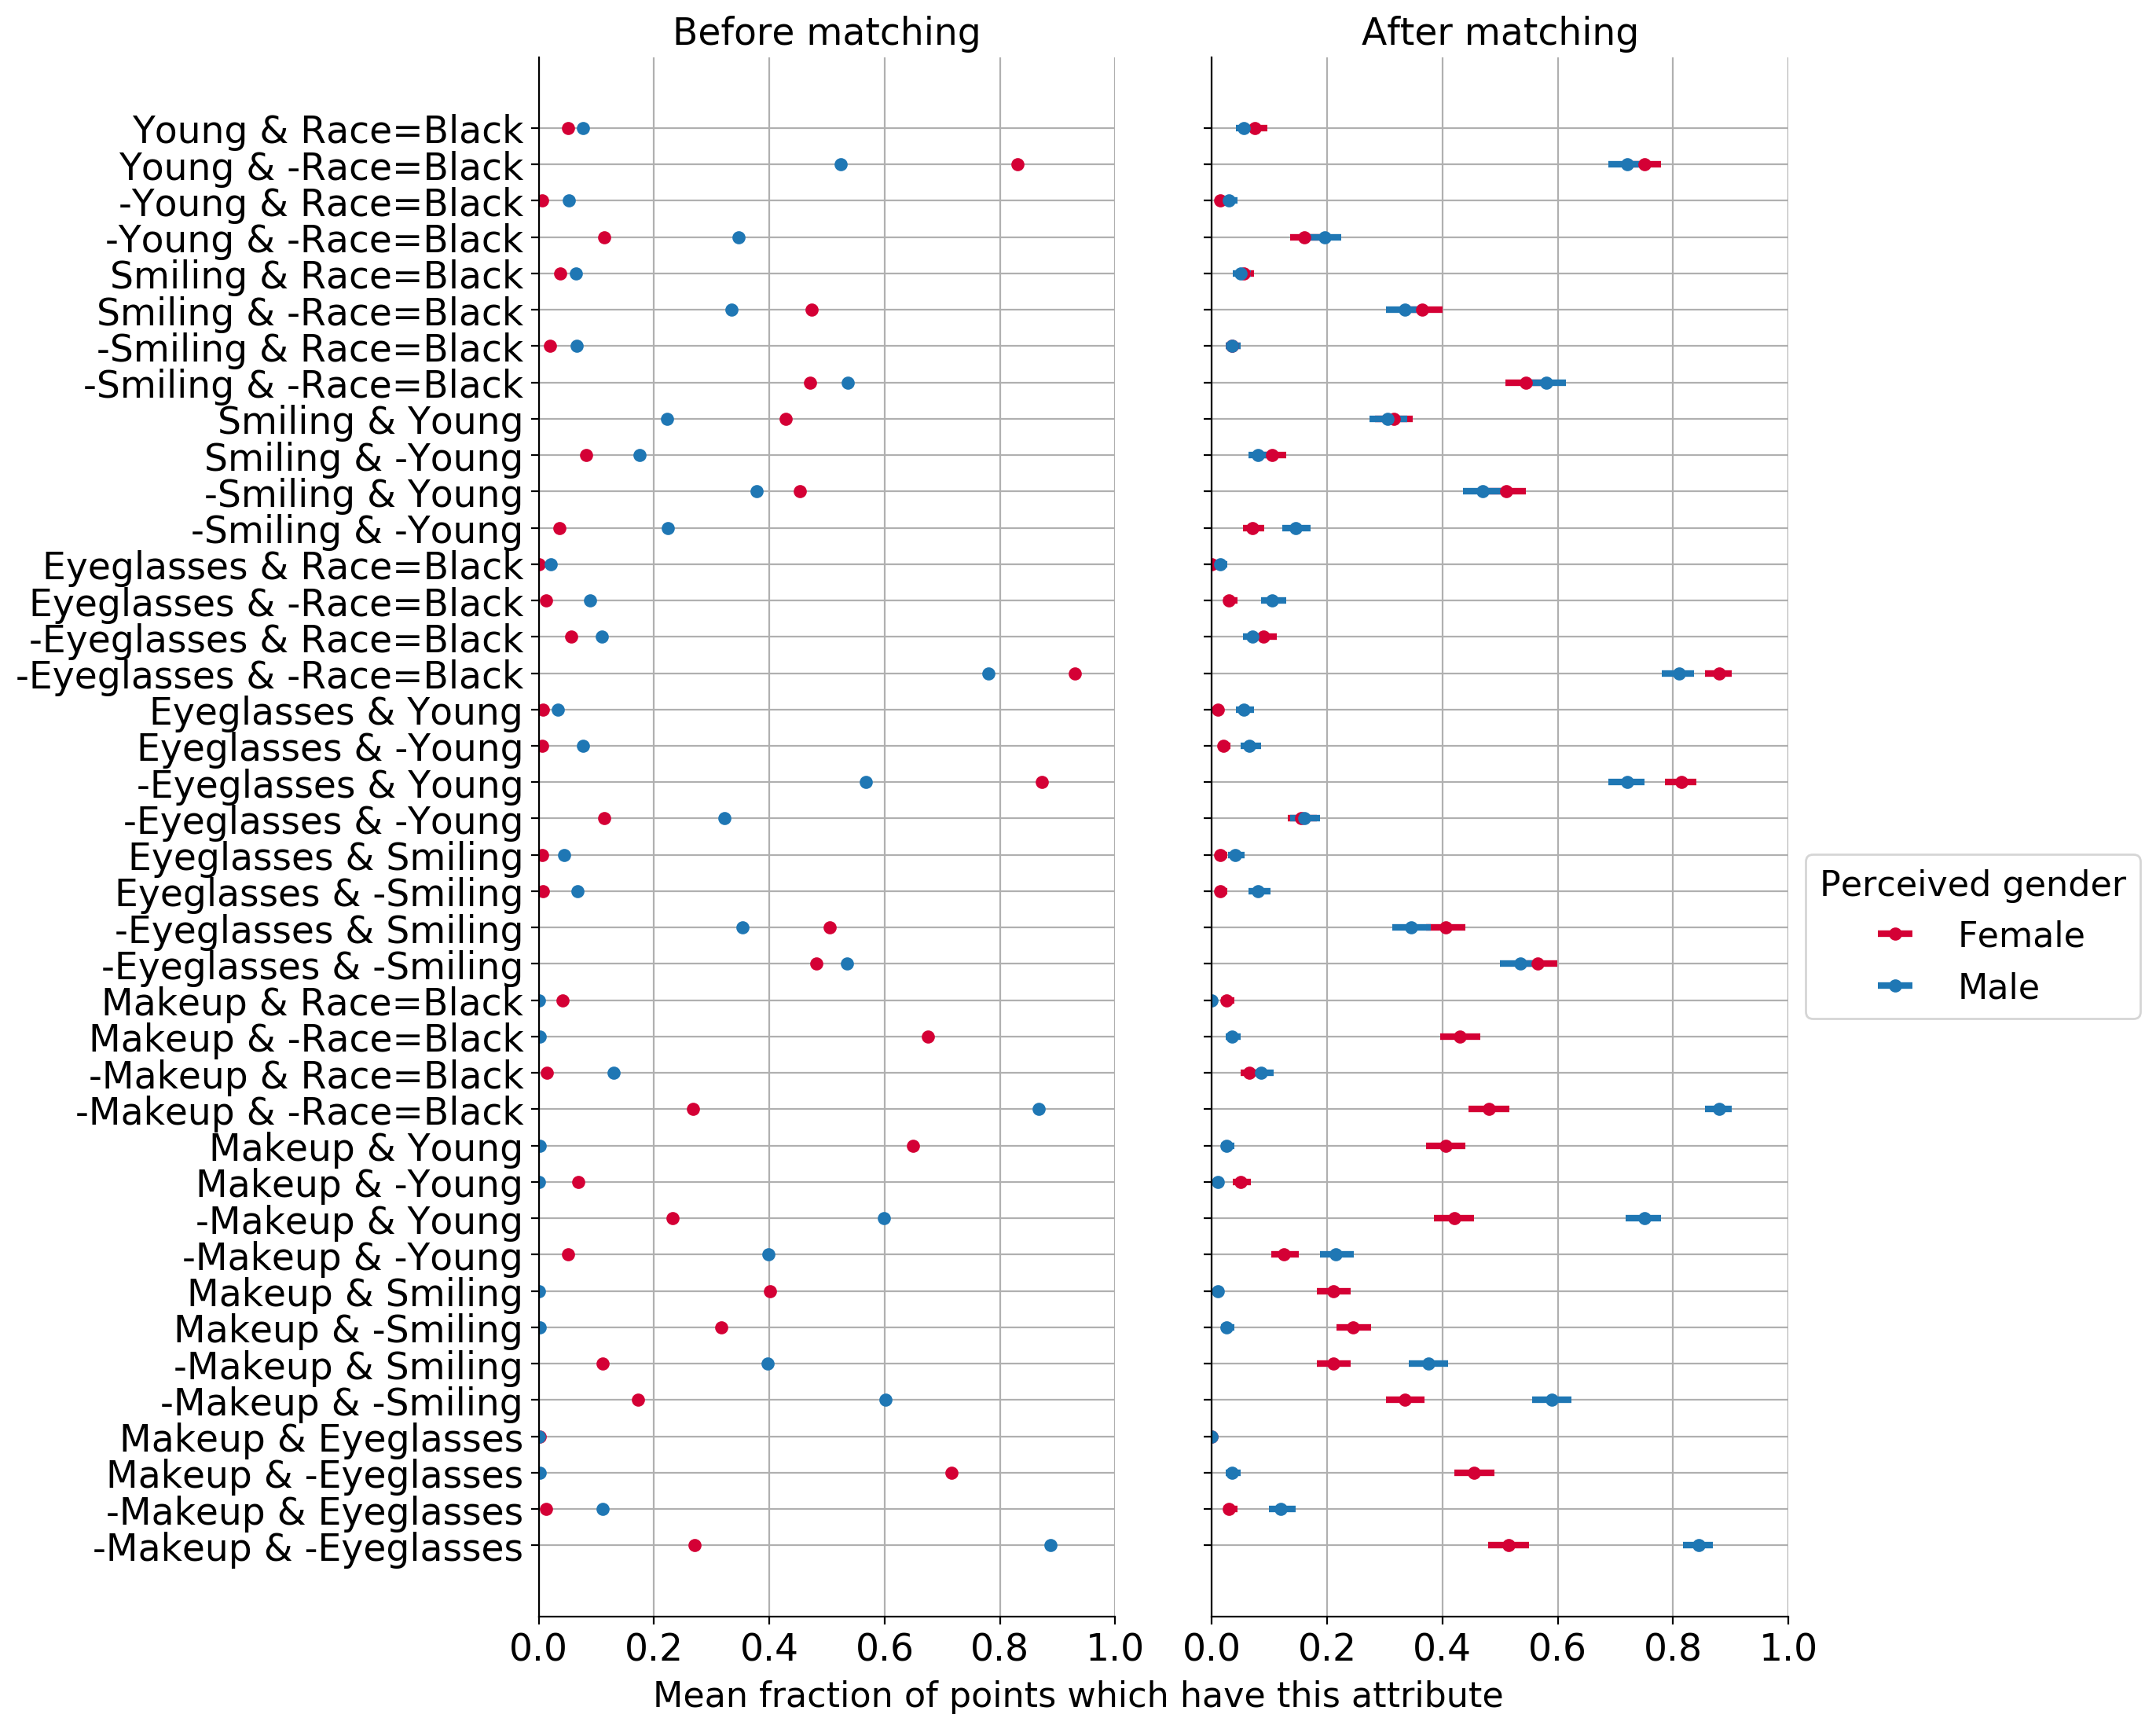

In [11]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(14, 11))
ks_init = ['Race=Black', 'young', 'smiling', 'eyeglasses', 'makeup', 'gender']
df_int, ks = matching.add_intersections(df, ks_init)
df_matched_int, ks = matching.add_intersections(df_matched, ks_init)
ds = [df_int, df_matched_int]
ks = ks[::-1] + ['gender']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, figsize=(14, 11))
util.savefig('means_intersectional_matching')
plt.show()

# examine 1-1 matches
**look at what fraction of matches preserve attributes**

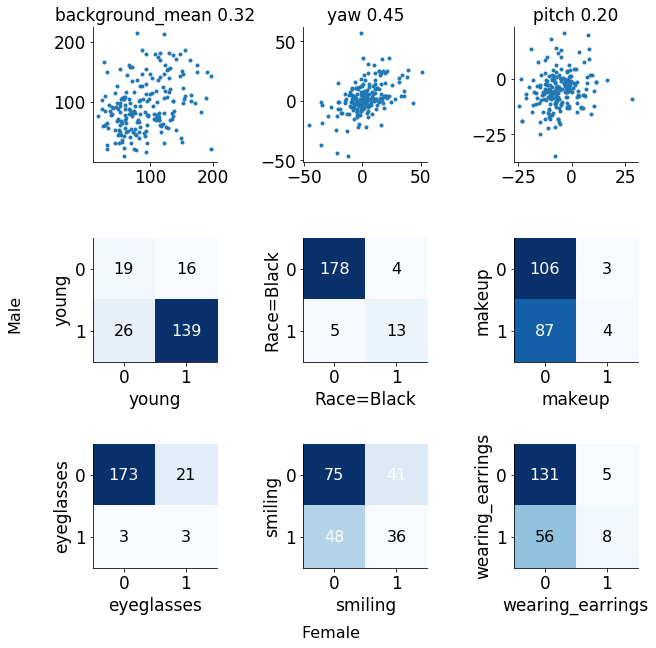

In [42]:
g0 = df.iloc[matches['gender_0']][:200]
g1 = df.iloc[matches['gender_1']][:200]

R, C = 3, 3
fig = plt.figure(figsize=(3 * C, 3 * R))
for i, k in enumerate(['background_mean', 'yaw', 'pitch',
                       'young', 'Race=Black', 'makeup', 'eyeglasses', 'smiling', 'wearing_earrings']):
    ax = plt.subplot(R, C, i + 1)
    
    if np.unique(g0[k]).size == 2:
        viz.plot_confusion_matrix(g0[k].values, g1[k].values, class_label=k, ax=ax)
    else:
        plt.plot(g0[k], g1[k], '.')
        plt.title(k + f' {scipy.stats.spearmanr(g0[k], g1[k]).correlation:.2f}')
        

plt.tight_layout()
fig.text(0.5, 0, 'Female', ha='center')
fig.text(0, 0.5, 'Male', va='center', rotation='vertical')
plt.show()

# reference-dist analysis for matches

In [2]:
dists_vgg = data.get_dists('vgg')

In [ ]:
density = True

# matched data
ks0 = [k for k in match_keys if '_0' in k]
ds_vgg0 = [dists_vgg[x[0], x[1]] for x in matches[ks0].values]
ks1 = [k for k in match_keys if '1' in k]
ds_vgg1 = [dists_vgg[x[0], x[1]] for x in matches[ks1].values]
plt.hist(ds_vgg0, density=density, bins=10)
plt.hist(ds_vgg1, density=density, alpha=0.5, bins=10)
plt.yscale('log')
plt.show()


# original data
ds_orig = {
    0: [],
    1: [],
}
for val in ds_orig.keys():
    d = df[df['count_with_this_id'] > 1]
    d = d[d[k_group] == val]
    ids = sorted(d.id.unique())
    for i in tqdm(ids):
        r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
        ds_orig[val].append(dists_vgg[r2[0], r2[1]])
plt.hist(ds_orig[0], density=density)
plt.hist(ds_orig[1], density=density, alpha=0.5)
plt.yscale('log')